<a href="https://colab.research.google.com/github/heerakesavan/CE888-Data-Science-and-Decision-making/blob/Master/Project%20Assignment%201/Sentiment_Heera_ce888_proj_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score ,confusion_matrix
import re
import gensim
from gensim import corpora
import pickle
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.feature_extraction import text 
import nltk
import operator
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer,PorterStemmer
from string import punctuation
from nltk.tokenize import word_tokenize
from collections import Counter
import warnings
warnings.filterwarnings("ignore")
from wordcloud import WordCloud
%matplotlib inline


In [ ]:
df_train = pd.read_fwf('https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/train_text.txt', header=None)
df_train.head()
df_train.columns
df_train.count
df_train.isnull().sum()
df_train=df_train.drop([1], axis = 1)
print(df_train.shape)
df_train=df_train.rename(columns={0:"Tweet"})
df_train.head()

(45615, 1)


,Tweet
0,"""QT @user In the original draft of the 7th boo..."
1,"""Ben Smith / Smith (concussion) remains out of..."
2,Sorry bout the stream last night I crashed out...
3,Chase Headley's RBI double in the 8th inning o...
4,@user Alciato: Bee will invest 150 million in ...


In [ ]:
df_train_labels=pd.read_fwf('https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/train_labels.txt', header=None)
df_train_labels.head()
print(df_train_labels.shape)
df_train_labels=df_train_labels.rename(columns={0:"Sentiment"})
df_train_labels.head()
#same number of rows in train labels and train text

(45615, 1)


,Sentiment
0,2
1,1
2,1
3,1
4,2


#### Merge Train text and labels for EDA - Train Data

In [ ]:
dfs=[df_train,df_train_labels]
df=pd.concat(dfs, axis=1, join="inner")
dforg=df
df.head()


,Tweet,Sentiment
0,"""QT @user In the original draft of the 7th boo...",2
1,"""Ben Smith / Smith (concussion) remains out of...",1
2,Sorry bout the stream last night I crashed out...,1
3,Chase Headley's RBI double in the 8th inning o...,1
4,@user Alciato: Bee will invest 150 million in ...,2


####Count plot for Sentiment Distribution

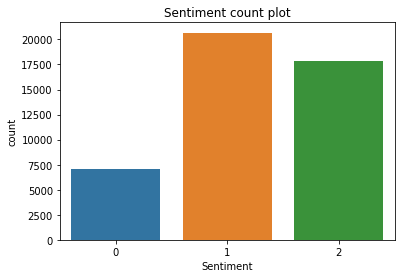

1    20673
2    17849
0     7093
Name: Sentiment, dtype: int64

In [ ]:
# create countplot for Target column
def createCP(df,x1):
    sns.countplot(x = x1, data = df)
    plt.title('Sentiment count plot')
    plt.show()

x = df.columns.tolist()[-1]   # last column is Target 'sentiment''
createCP(df, "Sentiment")
df["Sentiment"].value_counts()

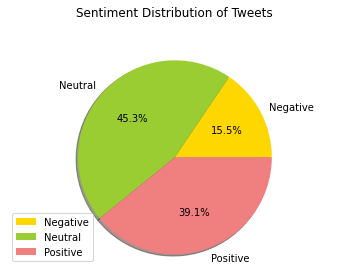

In [ ]:
  sentiments = [7093,20673,17849]
colors_list = ['gold', 'yellowgreen', 'lightcoral']
my_labels = 'Negative','Neutral','Positive'
plt.pie(sentiments,labels=my_labels,autopct='%1.1f%%',shadow=True,colors=colors_list)
plt.title('Sentiment Distribution of Tweets', y=1.12) 
plt.axis('equal') 
plt.legend(labels=my_labels, loc='lower left') 
plt.axis('equal')
plt.show()

######Mapping of Train Text Labels for Sentiment :  0 - Negative, 1 - Neutral, 2	- Positive
######Dataset imbalanced



###Hashtag Word Cloud

(-0.5, 799.5, 499.5, -0.5)

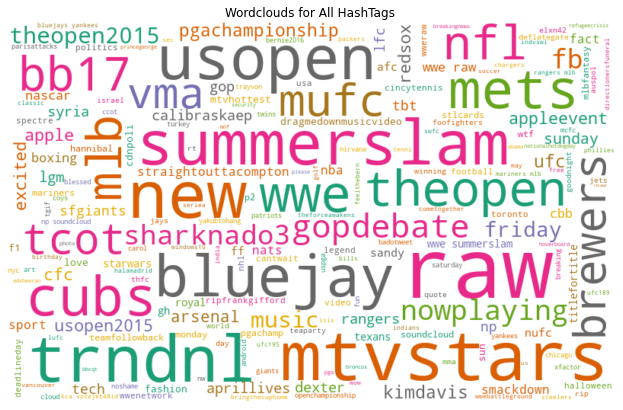

In [ ]:
train_n=df
## Adding hashtags as separate column and plotting Wordcloud
train_n['Hashtags']=train_n.Tweet.apply(lambda x:','.join(re.findall("#[\w]*", x)))
train_n['Hashtags']=train_n['Hashtags'].apply(lambda x:re.sub("[#]*","",x))
train_n['Hashtags'] =train_n['Hashtags'].apply(lambda x:x.lower())
hastag=','.join(train_n['Hashtags'])
# generate wordcloud object
wordcloud=WordCloud( background_color="white", colormap="Dark2",width=800, height=500, random_state=21, max_font_size=110).generate(hastag)
# plot wordcloud
plt.figure(figsize=(14,7))
plt.title('Wordclouds for All HashTags ')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

In [ ]:
df.head(2)

,Tweet,Sentiment,Hashtags
0,"""QT @user In the original draft of the 7th boo...",2,happybirthdayremuslupin
1,"""Ben Smith / Smith (concussion) remains out of...",1,"nhl,sj"


####Preprocessing Steps

#####Expand Contractions
#####Convert all text to lowercase
#####Remove Userhandles and Retweets
#####Remove html tags and urls 
#####Remove punctuation and digits
#####Remove stopword and lemmatization

####Contractions Expansion

In [ ]:
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, text)

# Expanding Contractions in the reviews
df['Tweet']=df['Tweet'].apply(lambda x:expand_contractions(x))


In [ ]:

import string
def clean_text(text):
    #convert the text to lower case
    text = text.lower()
    #remove @mention
    text = re.sub(r'@\w+', '', text)
    #remove Link word
    text = re.sub("{link}",'',text)
    #remove html tags
    text = re.sub("&[\w;]*",' ',text)
    #remove urls
    text = re.sub(r'http.?://[^\s]+[\s]?',' ',text)
    #remove RT
    text = re.sub(r'(?i)\bRT\b','',text)
    #remove content inside square brackets
    text = re.sub('\[.*?\]', ' ', text)
    #remove punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    #remove digits
    text = re.sub('\d+', ' ',text)
    #remove new line character
    text= re.sub('\n', '', text)
    return text

In [ ]:
df["Tweet"]= df.Tweet.apply(lambda x: clean_text(x))
df.Tweet.head(3)


0    qt  in the original draft of the  th book remu...
1    ben smith  smith concussion remains out of the...
2    sorry bout the stream last night i crashed out...
Name: Tweet, dtype: object

####Remove Stopwords and Lemmatize

In [ ]:
# Importing spacy
import spacy

# Loading model
nlp = spacy.load('en_core_web_sm',disable=['parser', 'ner'])

# Lemmatization with stopwords removal
df['Lemmatized']=df['Tweet'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))

In [ ]:
df.head()

,Tweet,Sentiment,Hashtags,Lemmatized
0,qt in the original draft of the th book remu...,2,happybirthdayremuslupin,qt original draft th book remus lupin surv...
1,ben smith smith concussion remains out of the...,1,"nhl,sj",ben smith smith concussion remain lineup thu...
2,sorry bout the stream last night i crashed out...,1,,sorry bout stream night crash tonight sure min...
3,chase headley is rbi double in the th inning ...,1,,chase headley rbi double th inning david pri...
4,alciato bee will invest million in january ...,2,,alciato bee invest million january sum...


In [ ]:
# import nltk
# nltk.download('stopwords')
# def remove_stopwords(input_text):
#     stopwords_list = stopwords.words('english')
#     words = input_text.split()
#     clean_words = [word for word in words if (word not in stopwords_list ) and len(word) > 2] 
#     return " ".join(clean_words)

# df["cleaned"] = df.Tweet.apply(lambda x: remove_stopwords(x))

In [ ]:
# import nltk
# nltk.download('punkt')
# from nltk import word_tokenize
# df["Tweet"] = [nltk.word_tokenize(x) for x in df["Tweet"]]
# df.head()


In [ ]:
#For later use
df1=df[["Tweet","Sentiment"]]
df.head()

,Tweet,Sentiment,Hashtags,Lemmatized
0,qt in the original draft of the th book remu...,2,happybirthdayremuslupin,qt original draft th book remus lupin surv...
1,ben smith smith concussion remains out of the...,1,"nhl,sj",ben smith smith concussion remain lineup thu...
2,sorry bout the stream last night i crashed out...,1,,sorry bout stream night crash tonight sure min...
3,chase headley is rbi double in the th inning ...,1,,chase headley rbi double th inning david pri...
4,alciato bee will invest million in january ...,2,,alciato bee invest million january sum...


####Lemmatization

In [ ]:
# nltk.download('wordnet')
# from nltk.corpus import wordnet
# from nltk.stem import WordNetLemmatizer
# def lemmatization(self,input_text):
#         words = input_text.split() 
#         lemma = WordNetLemmatizer()
#         lemma_words = [lemma.lemmatize(i) for i in words]
#         return " ".join(lemma_words)  
# df['Tweet'] = df['Tweet'].apply(lambda x: [lemmatizer.lemmatize(i) for i in x])
# df.head()

####Word Cloud for All words

(-0.5, 799.5, 499.5, -0.5)

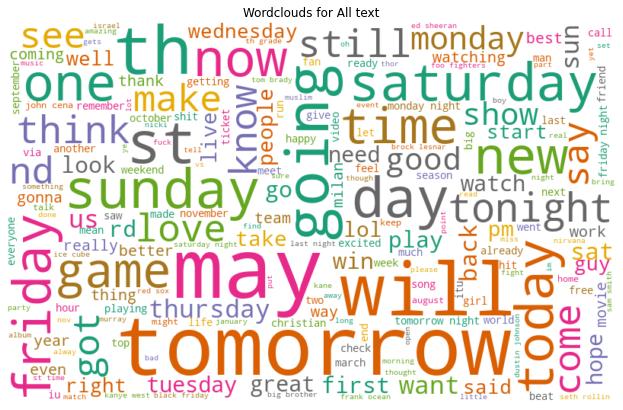

In [ ]:
# Whole tweet wordcloud
all_words=' '.join(df['Tweet'])

# generate wordcloud object
wordcloud=WordCloud( background_color="white", colormap="Dark2",width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
# plot wordcloud
plt.figure(figsize=(15,7))
plt.title('Wordclouds for All text')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

In [ ]:
label=[0,1,2]
new_data={}
for t in label:
    new_data[t]= ' '.join(df[df.Sentiment.isin([t])].Lemmatized)
#new_data

In [ ]:
#sentiment based DataFrame
train=pd.DataFrame(new_data.values(),index=new_data.keys(),columns=['Tweets'])
train.index=['Negative',' Neutral','Positive'] 
overall_train=train.copy()
overall_train

,Tweets
Negative,disappointed wwe summerslam want john cena win...
Neutral,ben smith smith concussion remain lineup thu...
Positive,qt original draft th book remus lupin surv...


In [ ]:
# Creating Document Term Matrix
from sklearn.feature_extraction.text import CountVectorizer 
cv = CountVectorizer(stop_words='english')
data_cv = cv.fit_transform(train.Tweets)
data_dtm = pd.DataFrame(data_cv.toarray(), index=train.index,columns=cv.get_feature_names())
data_stop=data_dtm.T
data_stop

,Negative,Neutral,Positive
aa,1,8,3
aaa,0,2,2
aaaa,1,0,1
aaaaaah,0,0,1
aaaaaahhhhh,0,0,1
...,...,...,...
zylona,0,0,1
zz,0,1,1
zzu,0,1,0
zzzzzz,0,1,0


In [ ]:
# Find the top 30 Trending words in each sentiments
top_dict = {}
for c in data_stop.columns:
    top = data_stop[c].sort_values(ascending=False).head(30)
    top_dict[c]= list(zip(top.index, top.values))

top_dict

{' Neutral': [('th', 2846),
  ('tomorrow', 2840),
  ('day', 1424),
  ('st', 1381),
  ('night', 1295),
  ('sunday', 1193),
  ('friday', 1175),
  ('time', 1078),
  ('like', 1009),
  ('game', 948),
  ('saturday', 948),
  ('come', 946),
  ('new', 928),
  ('nd', 909),
  ('want', 838),
  ('watch', 831),
  ('monday', 821),
  ('rd', 807),
  ('know', 794),
  ('say', 787),
  ('think', 785),
  ('play', 681),
  ('thursday', 619),
  ('today', 583),
  ('david', 545),
  ('pm', 544),
  ('sun', 514),
  ('start', 511),
  ('tonight', 511),
  ('win', 496)],
 'Negative': [('tomorrow', 888),
  ('th', 708),
  ('like', 600),
  ('st', 545),
  ('day', 485),
  ('time', 369),
  ('think', 356),
  ('want', 333),
  ('sunday', 324),
  ('bad', 315),
  ('say', 306),
  ('nd', 305),
  ('know', 299),
  ('rd', 291),
  ('watch', 289),
  ('friday', 285),
  ('night', 282),
  ('come', 266),
  ('game', 245),
  ('people', 227),
  ('fuck', 221),
  ('today', 220),
  ('saturday', 214),
  ('monday', 206),
  ('shit', 202),
  ('good',

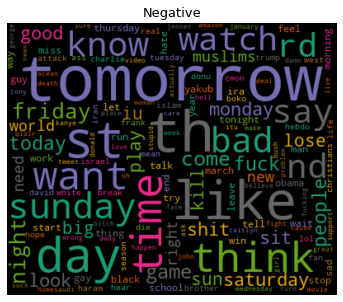

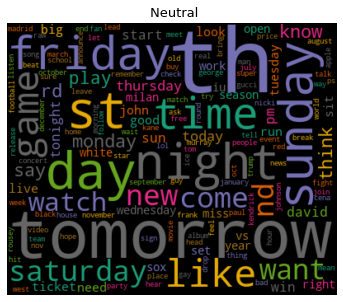

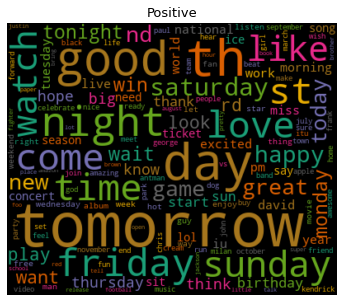

In [ ]:
# Importing wordcloud for plotting word clouds and textwrap for wrapping longer text
from wordcloud import WordCloud
from textwrap import wrap

# Function for generating word clouds
def generate_wordcloud(data,title):
  wc = WordCloud(width=400, height=330, max_words=150,colormap="Dark2").generate_from_frequencies(data)
  plt.figure(figsize=(7,5))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis("off")
  plt.title('\n'.join(wrap(title,60)),fontsize=13)
  plt.show()
  
# Transposing document term matrix
data_stop

# Plotting word cloud for each product
for index,product in enumerate(data_stop.columns):
  generate_wordcloud(data_stop[product].sort_values(ascending=False),product)

In [ ]:
df.head()

,Tweet,Sentiment,Hashtags,Lemmatized
0,qt in the original draft of the th book remu...,2,happybirthdayremuslupin,qt original draft th book remus lupin surv...
1,ben smith smith concussion remains out of the...,1,"nhl,sj",ben smith smith concussion remain lineup thu...
2,sorry bout the stream last night i crashed out...,1,,sorry bout stream night crash tonight sure min...
3,chase headley is rbi double in the th inning ...,1,,chase headley rbi double th inning david pri...
4,alciato bee will invest million in january ...,2,,alciato bee invest million january sum...


####Test Dataset

In [ ]:
#Loading Test Dataset
df_test1 = pd.read_fwf('https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/test_text.txt', header=None)
df_test1.head()
df_test1.columns
df_test1.count
print(df_test1.isnull().sum())
print(df_test1.shape)
df_test1=df_test1.rename(columns={0:"Tweet"})
df_test1.head()
df_test_labels=pd.read_fwf('https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/test_labels.txt', header=None)
df_test_labels.head()
print(df_test_labels.shape)
df_test_labels=df_train_labels.rename(columns={0:"Sentiment"})
df_test_labels.head()
dfs=[df_test1,df_test_labels]
df_test=pd.concat(dfs, axis=1, join="inner")
dft=df_test
df_test.head()

0    0
dtype: int64
(12284, 1)
(12284, 1)


,Tweet,Sentiment
0,@user @user what do these '1/2 naked pics' hav...,2
1,OH: “I had a blue penis while I was this” [pla...,1
2,"@user @user That's coming, but I think the vic...",1
3,I think I may be finally in with the in crowd ...,1
4,"@user Wow,first Hugo Chavez and now Fidel Cast...",2


In [ ]:
## Preprocessing in Test Data

##Contraction expansion test data


# Expanding Contractions in the reviews
df_test['Tweet']=df_test['Tweet'].apply(lambda x:expand_contractions(x))


# Cleaning tweet
df_test["Tweet"]= df_test.Tweet.apply(lambda x: clean_text(x))



##SVM Classification Train

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import time
from sklearn import svm
from sklearn.svm import SVC  
from sklearn.metrics import classification_report
X = df['Tweet']
X1 = df_test['Tweet']
y = df.Sentiment
tfidf = TfidfVectorizer()  #TF-IDF Vectoriser
Xt = tfidf.fit_transform(X)

X = Xt
y = df.Sentiment
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6)
model = SVC(kernel='linear', gamma = 6, random_state=0)   # SVC Model
model.fit(X_train, y_train) 
y_pred = model.predict(X_test)
print('SVM')
print('---------------------')
print(classification_report(y_test, y_pred))
print('')


SVM
---------------------
              precision    recall  f1-score   support

           0       0.64      0.36      0.46      1435
           1       0.62      0.78      0.69      4123
           2       0.73      0.64      0.68      3565

    accuracy                           0.66      9123
   macro avg       0.66      0.59      0.61      9123
weighted avg       0.67      0.66      0.65      9123




##SVM Classification Test

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import time
from sklearn import svm
from sklearn.svm import SVC  
from sklearn.metrics import classification_report
X1 = df_test['Tweet']
y = df_test.Sentiment
tfidf = TfidfVectorizer()  #TF-IDF Vectoriser
Xt = tfidf.fit_transform(X1)

X = Xt
y = df_test.Sentiment
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6)
model = SVC(kernel='linear', gamma = 6, random_state=0)   # SVC Model
model.fit(X_train, y_train) 
y_pred = model.predict(X_test)
print('SVM')
print('---------------------')
print(classification_report(y_test, y_pred))
print('')


SVM
---------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       380
           1       0.46      0.61      0.53      1132
           2       0.38      0.38      0.38       945

    accuracy                           0.43      2457
   macro avg       0.28      0.33      0.30      2457
weighted avg       0.36      0.43      0.39      2457


